# Tutorial2: Non-continuous Domains Detection with GLAND
This notebook demonstrates the workflow for using the GLAND model to identify non-continuous domains within hepatic lobular architectures.

## Environment Configuration


In [1]:
#First, we import the necessary libraries and configure the computation device. We also set the R_HOME environment variable to ensure mclust (required for clustering) functions correctly within the Python environment.
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
from sklearn.metrics import normalized_mutual_info_score
from GLAND import GLAND
from GLAND.utils import clustering

# Set computation device (GPU is highly recommended for GLAND training)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configure R environment for mclust algorithm
# Path automatically mapped to your GraphST-main conda environment
os.environ['R_HOME'] = r'/mnt/first19T/liufk/anaconda3/envs/GraphST-main/lib/R'

/mnt/first19T/liufk/anaconda3/envs/GLAND/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:3


## Data Loading and Preprocessing

In [2]:
#We will use the DLPFC (151672) dataset as an example. This step involves loading the Visium data and ensuring the gene names are unique.
# Configuration
dataset = 'JBO2_removed_20241224100803.h5ad'
n_clusters = 4  # Number of layers/clusters expected
file_fold = r'/mnt/first19T/liufk/x/'  # Path to your data directory

# Load Visium data
adata = sc.read_h5ad("/mnt/first19T/liufk/x/liver/"+dataset)
adata.var_names_make_unique()
print(f"Successfully loaded dataset {dataset}")
adata

Successfully loaded dataset JBO2_removed_20241224100803.h5ad


/mnt/first19T/liufk/anaconda3/envs/GLAND/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1363 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'UMAP_1', 'UMAP_2', 'spot', 'sample', 'type', 'cluster', 'zonation', 'zonationGroup', 'annotation', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Model Training and Spatial Clustering

Total number of points before filtering: 1363

Number of points per label before filtering:
Label Central: 153 points
Label Mid: 587 points
Label Periportal: 596 points
Label Portal: 27 points

Average LOF value per label:
Label Central: Average LOF = 1.0950
Label Mid: Average LOF = 0.9775
Label Periportal: Average LOF = 1.0479
Label Portal: Average LOF = 2.6107

Filtering top 3% by percentage, calculated threshold is: 1.6023

Total number of points after filtering: 1322
Number of points filtered out: 41

Number of points per label after filtering:
Label Central: 150 points
Label Mid: 585 points
Label Periportal: 583 points
Label Portal: 4 points


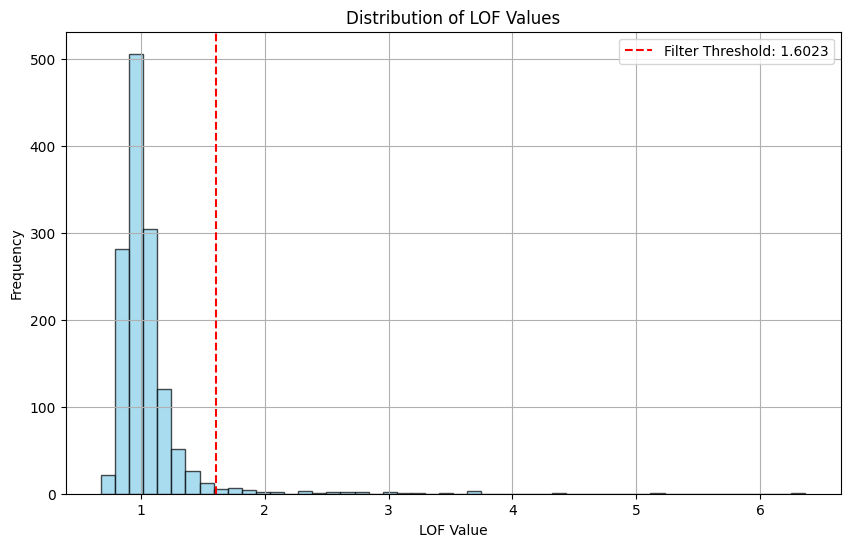

/mnt/first19T/liufk/GLAND/preprocess.py:115: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


Begin to train ST data...


 33%|█████████████████████████▋                                                    | 198/600 [00:05<00:10, 37.11it/s]

Updating adjacency matrix at epoch 200...


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 35.01it/s]


Optimization finished for ST data!


by .GlobalEnv when processing object ‘.pbd_env’
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [3]:
# Initialize the GLAND model
model = GLAND.GLAND(
    adata, 
    device=device, 
    epochs=600, 
    dataset=dataset, 
    n_clusters=n_clusters, lofk=13,dim_output=80,spLOF_threshold=3
)
# Train the model
adata = model.train()
# Clustering settings
radius = 50     # Radius for spatial refinement
# Refinement is recommended for the DLPFC dataset to reduce noise
clustering(adata, n_clusters, radius=radius, method='mclust', refinement=False) 

## Evaluation and Visualization

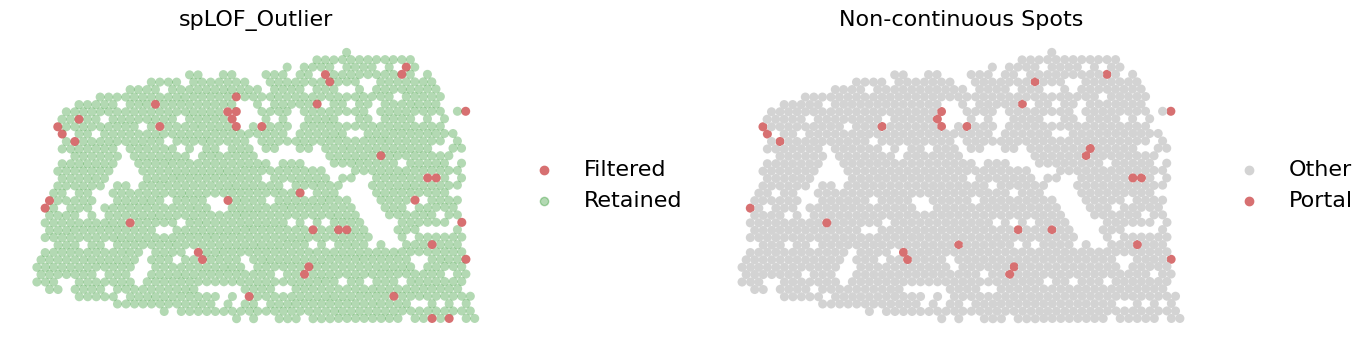

In [24]:
#This step visualizes the quality control results by highlighting spatial outliers detected via spLOF and identifying non-continuous spots within specific tissue structures
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scanpy as sc

# 1. Prepare data (Grouping)
adata.obs['plot_group'] = adata.obs['ground_truth'].astype(str).where(lambda x: x == 'Portal', 'Other').astype('category')

# 2. Define palettes
palettes = {
    "lof_outlier": {"Filtered": mcolors.to_rgba("#D77071", 1.0), "Retained": mcolors.to_rgba("green", 0.3)},
    "plot_group": {"Portal": mcolors.to_rgba("#D77071", 1.0), "Other": mcolors.to_rgba("lightgray", 1.0)}
}

# 3. Plotting
titles = ["spLOF_Outlier", "Non-continuous Spots"]
with plt.rc_context({'font.size': 16, 'axes.titlesize': 16, 'legend.fontsize': 16}):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    for i, col in enumerate(["lof_outlier", "plot_group"]):
        sc.pl.spatial(adata, color=col, title=titles[i], spot_size=35, palette=palettes[col], 
                      frameon=False, show=False, ax=axs[i], img_key=None)
    plt.tight_layout()
    plt.show()

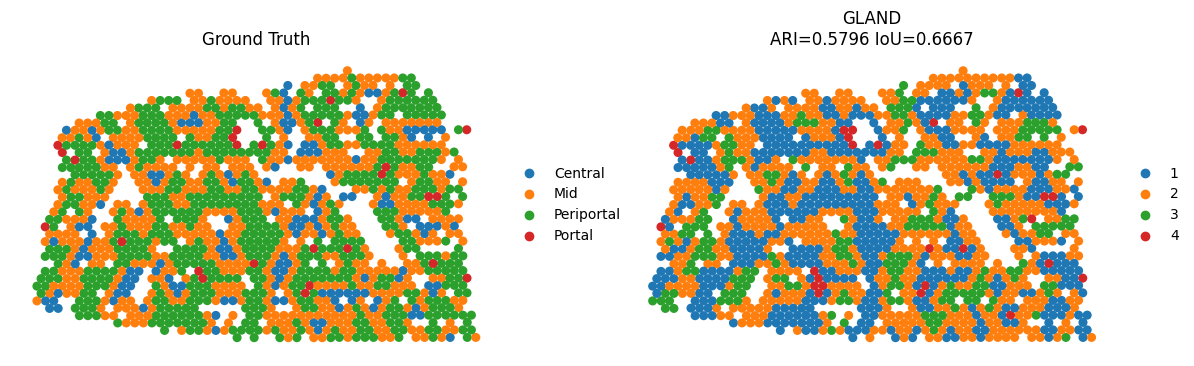

In [25]:
#Since unsupervised clustering labels (e.g., cluster 1, 2, 3) do not inherently match biological labels (e.g., Portal, Mid), we use a permutation approach to find the best label mapping that maximizes the overlap for specific tissue structures.
import numpy as np
import pandas as pd
import scanpy as sc
from itertools import permutations
from sklearn import metrics
from sklearn.metrics import normalized_mutual_info_score

mask = adata.obs['ground_truth'].notna() & adata.obs['domain'].notna()
adata = adata[mask].copy()

def get_metrics(mapping, adata):
    """Calculate IoU for all labels based on a mapping."""
    gt = adata.obs['ground_truth'].map(mapping)
    dt = adata.obs['domain'].astype(int)
    
    res = {}
    for label, cluster_id in mapping.items():
        inter = np.sum((gt == cluster_id) & (dt == cluster_id))
        union = np.sum((gt == cluster_id) | (dt == cluster_id))
        res[label] = inter / union if union > 0 else 0
    return res

target_labels = ["Portal", "Mid", "Central", "Periportal"]
cluster_ids = range(1, len(target_labels) + 1)

best_iou_scores = max(
    (get_metrics(dict(zip(target_labels, p)), adata) for p in permutations(cluster_ids)),
    key=lambda x: x.get("Portal", 0)
)

ari, nmi = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth']), \
           normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])

adata.uns.update({'IoU_Scores': best_iou_scores, 'ARI': ari, 'NMI': nmi})

portal_iou = best_iou_scores.get("Portal", 0)
sc.pl.spatial(
    adata, color=["ground_truth", "domain"], spot_size=35, frameon=False,img_key=None,
    title=["Ground Truth", f"GLAND\nARI={ari:.4f} IoU={portal_iou:.4f}"]
)